### Bibliotecas

In [1]:
"""%pip install aeon
%pip install tsfresh
%pip install tslearn
%pip install tensorflow
%pip install keras
%pip install pywavelets"""

'%pip install aeon\n%pip install tsfresh\n%pip install tslearn\n%pip install tensorflow\n%pip install keras\n%pip install pywavelets'

In [91]:
import pandas as pd
import numpy as np

from aeon.datasets import load_classification
from aeon.datasets.tsc_data_lists import univariate_equal_length
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from aeon.classification.interval_based import SupervisedTimeSeriesForest, TimeSeriesForestClassifier

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

import pywt
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from aeon.classification.sklearn import RotationForestClassifier
from scipy.fftpack import fft, ifft
from numba import jit
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### Dados

In [3]:
@staticmethod
def load_data(dataset):
    # LabelEncoder para labels alvo
    le = LabelEncoder()

    # Carregar conjunto de dados do repositório UCR
    X_train, y_train = load_classification(dataset, split="TRAIN")
    X_test, y_test = load_classification(dataset, split="test")

    # Formatar o conjunto de dados para 2D
    features_train = X_train.reshape(X_train.shape[0], -1)
    features_test = X_test.reshape(X_test.shape[0], -1)

    # Ajustar e transformar as labels alvo
    target_train = le.fit_transform(y_train)
    target_test = le.transform(y_test)

    return features_train, features_test, target_train, target_test


### Função de transformação dos dados (2D)

In [4]:
def choose_wavelet(X):
    min_variance = float('inf')
    best_wavelet = None
    candidate_wavelets = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9']

    for wavelet_type in candidate_wavelets:
        _, coeffs_cD = pywt.dwt(X, wavelet_type, axis=1)
        total_variance = np.var(coeffs_cD)

        if total_variance < min_variance:
            min_variance = total_variance
            best_wavelet = wavelet_type
    return str(best_wavelet)


@jit
def transform_data_math(X, wavelet):
    n_sax_symbols = int(X.shape[1] / 4)
    n_paa_segments = int(X.shape[1] / 4)

    X_fft = np.abs(fft(X, axis=1))

    coeffs_cA, coeffs_cD = pywt.dwt(X, wavelet=wavelet, axis=1, mode='periodization')
    X_dwt = np.hstack((coeffs_cA, coeffs_cD))

    paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
    X_paa_ = paa.inverse_transform(paa.fit_transform(X))
    X_paa = X_paa_.reshape(X_paa_.shape[0], -1)
    stats_PAA = np.hstack([np.mean(X_paa, axis=1).reshape(-1,1),
                           np.std(X_paa, axis=1).reshape(-1,1),
                           np.max(X_paa, axis=1).reshape(-1,1),
                           np.min(X_paa, axis=1).reshape(-1,1),
                           ])

    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
    X_sax_ = sax.inverse_transform(sax.fit_transform(X))
    X_sax = X_sax_.reshape(X_sax_.shape[0], -1)
    stats_SAX = np.hstack([np.mean(X_sax, axis=1).reshape(-1,1),
                           np.std(X_sax, axis=1).reshape(-1,1),
                           np.max(X_sax, axis=1).reshape(-1,1),
                           np.min(X_sax, axis=1).reshape(-1,1),
                           ])

    data_X = TimeSeriesScalerMeanVariance().fit_transform(X)
    data_X.resize(data_X.shape[0], data_X.shape[1])
    stats_X = np.hstack([np.mean(data_X, axis=1).reshape(-1,1),
                         np.std(data_X, axis=1).reshape(-1,1),
                         np.max(data_X, axis=1).reshape(-1,1),
                         np.min(data_X, axis=1).reshape(-1,1),
                         ])

    data_FFT = TimeSeriesScalerMeanVariance().fit_transform(X_fft)
    data_FFT.resize(data_FFT.shape[0], data_FFT.shape[1])
    stats_FFT = np.hstack([np.mean(data_FFT, axis=1).reshape(-1,1),
                           np.std(data_FFT, axis=1).reshape(-1,1),
                           np.max(data_FFT, axis=1).reshape(-1,1),
                           np.min(data_FFT, axis=1).reshape(-1,1),
                           ])

    data_DWT = TimeSeriesScalerMeanVariance().fit_transform(X_dwt)
    data_DWT.resize(data_DWT.shape[0], data_DWT.shape[1])
    stats_DWT = np.hstack([np.mean(data_DWT, axis=1).reshape(-1,1),
                           np.std(data_DWT, axis=1).reshape(-1,1),
                           np.max(data_DWT, axis=1).reshape(-1,1),
                           np.min(data_DWT, axis=1).reshape(-1,1),
                           ])

    return {
        "TS": np.hstack([data_X, stats_X]),
        "FFT": np.hstack([data_FFT, stats_FFT]),
        "DWT": np.hstack([data_DWT, stats_DWT]),
        "PAA": np.hstack([X_paa, stats_PAA]),
        "SAX": np.hstack([X_sax, stats_SAX])
    }

### Seleção do modelo extrator e modelo classificador

In [5]:
@staticmethod
def select_model(option, random_state):
    if option == '1nn':
        return KNeighborsTimeSeriesClassifier(distance='euclidean', n_neighbors=1, n_jobs=-1)
    elif option == '3nn':
        return KNeighborsTimeSeriesClassifier(distance='dtw', n_neighbors=3, n_jobs=-1)
    elif option == 'svm':
        return SVC(C = 100, gamma=0.1, kernel='linear', probability=True, cache_size=200, max_iter=-1, decision_function_shape='ovr', tol=1e-3)
    elif option == 'gbc':
        return GradientBoostingClassifier(n_estimators=5, random_state=random_state)
    elif option == 'nb':
        return GaussianNB()
    elif option == 'lr':
        return LogisticRegression(n_jobs=-1, max_iter=5000, solver="liblinear", dual=True, penalty="l2", random_state=random_state)
    elif option == 'exrf':
        return ExtraTreesClassifier(n_estimators=200, criterion="entropy", max_features="sqrt", n_jobs=-1, random_state=None)
    elif option == 'rd':
        return RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    else:
        return RandomForestClassifier(n_estimators=200, criterion="gini", max_features="sqrt", n_jobs=-1, random_state=None)


### AmazonForestClassifier

In [6]:
"""@jit
def train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='rd', random_state=42, wavelet=None):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    X_train_transformed = transform_data_math(X_train, wavelet)  # Transformar todo o conjunto de treino
    loo = LeaveOneOut()
    num_classes = len(np.unique(y_train))  # Número de classes

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, colour='red', desc="Training Models"):
        model = CombinedDecisionForest()  # Utilizar o CombinedDecisionForest como modelo base
        for train_index, _ in loo.split(X_trans):
            model.fit(X_trans[train_index], y_train[train_index])
        trained_models[rep] = model  # Salvar o modelo treinado

    # Preparar dados para o meta-classificador
    meta_features = np.zeros((X_train.shape[0], num_classes))  # Inicializar um vetor para armazenar as somas de probabilidades para cada classe
    for i in range(X_train.shape[0]):
        for rep, model in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            meta_features[i] += proba.flatten()  # Adicione as probabilidades para cada classe

    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)

    return trained_models, meta_classifier

def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier,):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste

    for i in tqdm(range(len(X_test)), ascii=True, colour='green', desc="Predict"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data_math(x_instance, wavelet=wavelet)

        instance_features = np.zeros(trained_meta_classifier.n_features_in_)  # Inicialize um vetor para armazenar as características do meta-classificador
        for rep, model in trained_base_models.items():
            proba = model.predict(x_transformed[rep][0].reshape(1, -1))
            instance_features += proba.flatten()  # Adicione as probabilidades para cada classe

        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões

        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista

    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    return predictions

"""

'@jit\ndef train_with_meta_classifier(X_train, y_train, base_option=\'svm\', meta_option=\'rd\', random_state=42, wavelet=None):\n    trained_models = {}  # Salvar modelos treinados para cada transformação\n    X_train_transformed = transform_data_math(X_train, wavelet)  # Transformar todo o conjunto de treino\n    loo = LeaveOneOut()\n    num_classes = len(np.unique(y_train))  # Número de classes\n\n    # Treinar um modelo para cada transformação e salvar no dicionário\n    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, colour=\'red\', desc="Training Models"):\n        model = CombinedDecisionForest()  # Utilizar o CombinedDecisionForest como modelo base\n        for train_index, _ in loo.split(X_trans):\n            model.fit(X_trans[train_index], y_train[train_index])\n        trained_models[rep] = model  # Salvar o modelo treinado\n\n    # Preparar dados para o meta-classificador\n    meta_features = np.zeros((X_train.shape[0], num_classes))  # Inicializar um vet

### Treino do modelos extrator e classificador - (CalibrationProba)

In [7]:
@jit
def train_with_meta_classifier(X_train, y_train, base_option='None', meta_option='None', random_state=42, wavelet=None):
    num_classes = len(np.unique(y_train))
    trained_models = {}  # Salvar modelos treinados para cada transformação
    X_train_transformed = transform_data_math(X_train, wavelet)  # Transformar todo o conjunto de treino

    loo = LeaveOneOut()

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, colour='red', desc="Training Base Models"):
        model = select_model(base_option, random_state)
        scores = []
        for train_index, _ in loo.split(X_trans):
            model.fit(X_trans[train_index], y_train[train_index])
            score = model.score(X_trans[train_index], y_train[train_index])  # Score do modelo nos dados de treino
            scores.append(score)
        avg_score = np.mean(scores)
        trained_models[rep] = (model, avg_score)  # Salvar o modelo treinado e a média dos scores

    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, (model, _) in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())
        meta_features.append(instance_features)

    meta_features = np.array(meta_features)

    # Calibrar as probabilidades dos classificadores base
    calibrated_classifiers = []
    for rep, (model, _) in trained_models.items():
        calibrated_classifier = CalibratedClassifierCV(model, method='sigmoid', cv=3, n_jobs=-1)
        calibrated_classifier.fit(X_train_transformed[rep], y_train)
        calibrated_classifiers.append((rep, calibrated_classifier))

    # Preparar dados calibrados para o meta-classificador
    calibrated_meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, calibrated_classifier in calibrated_classifiers:
            proba = calibrated_classifier.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())
        calibrated_meta_features.append(instance_features)

    calibrated_meta_features = np.array(calibrated_meta_features)

    # Treinar o meta-classificador (utilizando MLP como exemplo)
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(calibrated_meta_features, y_train)

    return calibrated_classifiers, meta_classifier


### Predicao do meta-classificador - (CalibrationProba)

In [8]:
@jit
def predict_with_meta_classifier(X_test, calibrated_base_models, trained_meta_classifier, wavelet=None):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste

    for i in tqdm(range(len(X_test)), ascii=True, colour='green', desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data_math(x_instance, wavelet)

        instance_features = []
        for rep, calibrated_classifier in calibrated_base_models:
            proba = calibrated_classifier.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades

        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões

        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista

    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)
    return predictions

### Train/Predict (ArgmaxProba)

In [9]:
"""def combine_and_predict(X_transformed, trained_models):
    num_instances = len(next(iter(X_transformed.values())))  # Number of instances from the first transformed data
    num_classes = len(trained_models[next(iter(trained_models))].classes_)  # Number of classes from first model
    combined_probabilities = np.zeros((num_instances, num_classes))

    for transformation_type, X_trans in X_transformed.items():
        model = trained_models[transformation_type]
        proba = model.predict_proba(X_trans)  # Get probabilities for all instances
        combined_probabilities += proba

    combined_probabilities_reshaped = combined_probabilities.reshape(num_instances, -1, num_classes)
    predicted_classes = np.argmax(combined_probabilities_reshaped, axis=1) + 1  # Adding 1 to start classes from 1 instead of 0
    return predicted_classes

def train_with_meta_classifier(X_train, y_train, base_option='1nn', meta_option='rf', random_state=123, wavelet=None):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    X_train_transformed = transform_data_math(X_train, wavelet)  # Transformar todo o conjunto de treino
    loo = LeaveOneOut()

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, colour='red', desc="Training Models"):
        model = select_model(base_option, random_state)
        for train_index, _ in loo.split(X_trans):
            model.fit(X_trans[train_index], y_train[train_index])
        trained_models[rep] = model  # Salvar o modelo treinado

    avg_proba = combine_and_predict(X_train_transformed, trained_models)
    # Train meta-classifier
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(avg_proba, y_train)

    return trained_models, meta_classifier

def predict_with_meta_classifier(X_test, trained_models, trained_meta_classifier, wavelet=None):
    predictions = []
    meta_features_test = []
    for i in tqdm(range(len(X_test)), ascii=True, colour='green', desc="Testing Instances"):
        x_instance = X_test[i].reshape(1,-1)
        x_transformed = transform_data_math(x_instance, wavelet)
        avg_proba = combine_and_predict(x_transformed, trained_models)
        meta_feature = avg_proba
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])
        meta_features_test.append(meta_feature)
    meta_features_test = np.array(meta_features_test)
    return predictions
"""

'def combine_and_predict(X_transformed, trained_models):\n    num_instances = len(next(iter(X_transformed.values())))  # Number of instances from the first transformed data\n    num_classes = len(trained_models[next(iter(trained_models))].classes_)  # Number of classes from first model\n    combined_probabilities = np.zeros((num_instances, num_classes))\n\n    for transformation_type, X_trans in X_transformed.items():\n        model = trained_models[transformation_type]\n        proba = model.predict_proba(X_trans)  # Get probabilities for all instances\n        combined_probabilities += proba\n\n    combined_probabilities_reshaped = combined_probabilities.reshape(num_instances, -1, num_classes)\n    predicted_classes = np.argmax(combined_probabilities_reshaped, axis=1) + 1  # Adding 1 to start classes from 1 instead of 0\n    return predicted_classes\n\ndef train_with_meta_classifier(X_train, y_train, base_option=\'1nn\', meta_option=\'rf\', random_state=123, wavelet=None):\n    train

### Testando um único modelo - Random Forest como extrator e SVM como meta-classificador

In [10]:
dataset_quali_list = ['Adiac', 'Beef', 'Car', 'CBF', 'Coffee', 'DiatomSizeReduction', 'ECG200', 'ECGFiveDays', 'FaceFour','GunPoint', 'Lightning2', 'Lightning7', 'MedicalImages', 'MoteStrain', 'OliveOil', 'SonyAIBORobotSurface1','SonyAIBORobotSurface2', 'SyntheticControl', 'Trace']
dataset_full_list = ['Worms','FaceAll','SemgHandMovementCh2','Herring','GunPointAgeSpan','SmoothSubspace','SemgHandSubjectCh2','LargeKitchenAppliances','Plane','Fish','ScreenType','PhalangesOutlinesCorrect','CricketZ','MiddlePhalanxOutlineAgeGroup','ECG5000','Chinatown','ShapeletSim','MiddlePhalanxTW','Symbols','EOGHorizontalSignal','Ham','UMD','HouseTwenty','MiddlePhalanxOutlineCorrect','Wafer','Rock','DistalPhalanxTW','CricketY','FacesUCR','FiftyWords','Mallat','Strawberry','SwedishLeaf','ProximalPhalanxOutlineAgeGroup','MixedShapesRegularTrain','SmallKitchenAppliances','GunPointOldVersusYoung','Wine','ProximalPhalanxOutlineCorrect','WordSynonyms', 'RefrigerationDevices','Yoga','CinCECGTorso','ChlorineConcentration','ArrowHead','ToeSegmentation1','TwoLeadECG','ProximalPhalanxTW','InsectEPGSmallTrain','WormsTwoClass','PowerCons','InsectEPGRegularTrain','GunPointMaleVersusFemale','DistalPhalanxOutlineCorrect','ItalyPowerDemand','InsectWingbeatSound','BME','NonInvasiveFetalECGThorax2','CricketX','Haptics','EOGVerticalSignal','MixedShapesSmallTrain','Meat','SemgHandGenderCh2','ToeSegmentation2','NonInvasiveFetalECGThorax1','FreezerSmallTrain','OSULeaf','Earthquakes','BirdChicken','HandOutlines','BeetleFly','ACSF1','DistalPhalanxOutlineAgeGroup','FreezerRegularTrain']
problematicos = ['Crop','EthanolLevel','ElectricDevices','FordB','ShapesAll','StarLightCurves','Phoneme', 'Computers','InlineSkate','PigAirwayPressure', 'PigCVP','FordA','MedicalImages','PigArtPressure', 'UWaveGestureLibraryX','UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'UWaveGestureLibraryAll', 'TwoPatterns']

In [74]:
features_train, features_test, target_train, target_test = load_data('CBF')

array([0, 0, 0, 2, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1,
       0, 0, 2, 2, 1, 2, 2, 0], dtype=int64)

In [151]:
X_fft = np.abs(fft(features_train, axis=1))
x_ifft = np.abs(ifft(features_train))

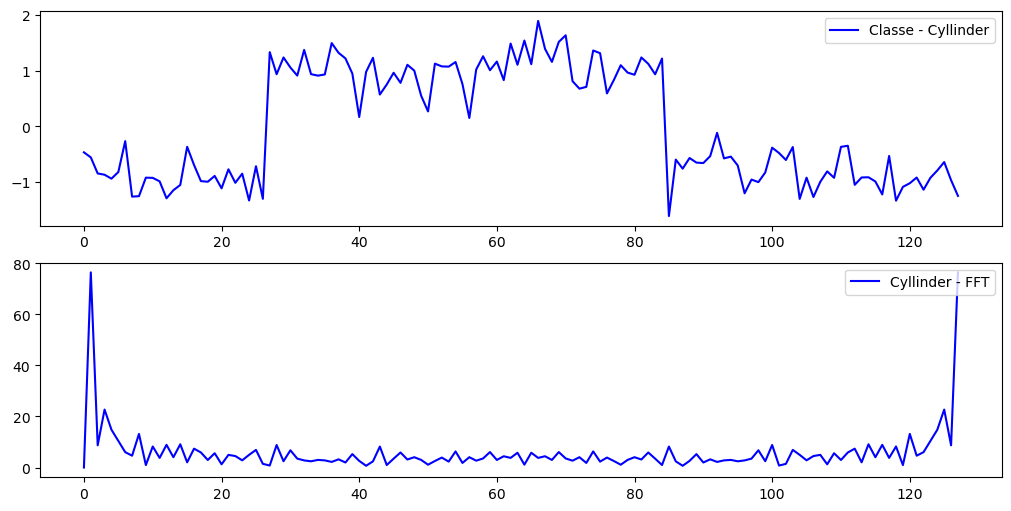

In [190]:
import matplotlib.pyplot as plt

s1 = features_train[0]
s2 = X_fft[0]

fig, ax = plt.subplots(2,1, constrained_layout=True, figsize=(10,5))  # Corrigido o argumento 'layout' para 'constrained_layout'

ax[0].plot(s1, label='Classe - Cyllinder', color='blue')  # Adicionando legenda e mudando a cor para azul
ax[1].plot(s2, label='Cyllinder - FFT', color='blue')  

ax[0].legend(loc='upper right', bbox_to_anchor=(1, 1))
ax[1].legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.show()


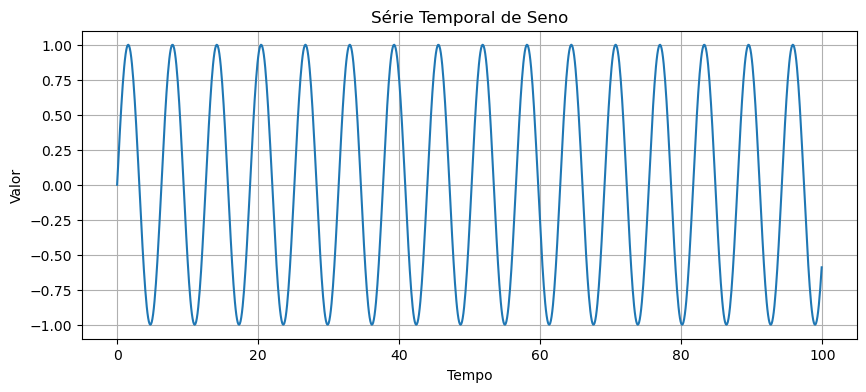

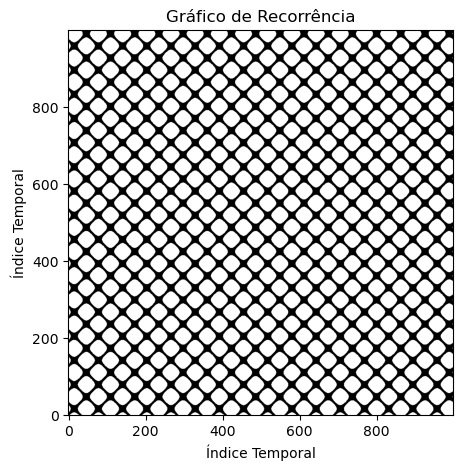

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot

# Gerando uma série temporal simples (seno)
t = np.arange(0, 100, 0.1)
serie_temporal = np.sin(t)

# Plot da série temporal
plt.figure(figsize=(10, 4))
plt.plot(t, serie_temporal)
plt.title('Série Temporal de Seno')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Transformação da série temporal em um gráfico de recorrência
rp = RecurrencePlot(threshold='distance', percentage=20)
X_rp = rp.fit_transform(serie_temporal.reshape(1, -1))

# Plot do gráfico de recorrência
plt.figure(figsize=(5, 5))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title('Gráfico de Recorrência')
plt.xlabel('Índice Temporal')
plt.ylabel('Índice Temporal')
plt.show()


In [192]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Gerando uma série temporal artificial
t = np.linspace(0, 20, num=1000)
serie_temporal = np.sin(t) + np.random.normal(scale=0.1, size=1000)

# Função para transformar a série temporal em imagens de recorrência
def transform_to_rp(data, window_size, threshold):
    rp = RecurrencePlot(threshold=threshold)
    X_rp = rp.fit_transform(data.reshape(1, -1))
    return X_rp[0]

# Definindo parâmetros
window_size = 50  # Tamanho da janela
threshold = 'distance'  # Limiar de recorrência

# Transformando a série temporal em imagens de recorrência
X_rp = []
for i in range(len(serie_temporal) - window_size):
    window = serie_temporal[i:i+window_size]
    rp = transform_to_rp(window, window_size, threshold)
    X_rp.append(rp)

X_rp = np.array(X_rp)

# Criando labels para os dados
y = np.where(np.roll(serie_temporal, -window_size) > serie_temporal, 1, 0)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_rp, y[:-window_size], test_size=0.2, random_state=42)

# Construindo o modelo CNN
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((window_size, window_size, 1), input_shape=(window_size, window_size)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia do modelo: {accuracy}')


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4683 - loss: 0.7705 - val_accuracy: 0.5368 - val_loss: 0.6916
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6070 - loss: 0.6881 - val_accuracy: 0.6000 - val_loss: 0.6692
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6298 - loss: 0.6454 - val_accuracy: 0.6842 - val_loss: 0.6148
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7491 - loss: 0.5415 - val_accuracy: 0.6263 - val_loss: 0.6372
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8161 - loss: 0.4221 - val_accuracy: 0.7684 - val_loss: 0.4821
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9033 - loss: 0.2843 - val_accuracy: 0.7263 - val_loss: 0.5371
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9594 - loss: 0.1927 - val_accuracy: 0.8526 - val_loss: 0.3439
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9834 - loss: 0.1091 - val_accuracy: 0.8947 - v

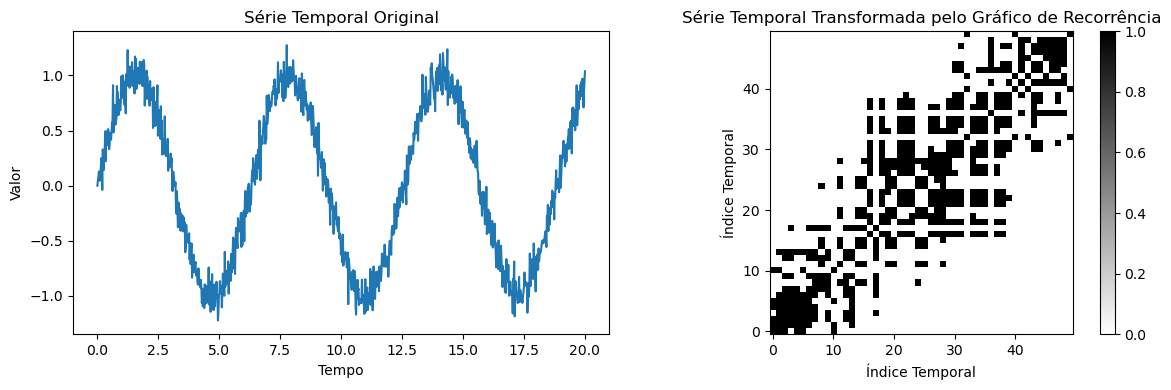

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Gerando uma série temporal artificial
t = np.linspace(0, 20, num=1000)
serie_temporal = np.sin(t) + np.random.normal(scale=0.1, size=1000)

# Função para transformar a série temporal em imagens de recorrência
def transform_to_rp(data, window_size, threshold):
    rp = RecurrencePlot(threshold=threshold)
    X_rp = rp.fit_transform(data.reshape(1, -1))
    return X_rp[0]

# Definindo parâmetros
window_size = 50  # Tamanho da janela
threshold = 'distance'  # Limiar de recorrência

# Transformando a série temporal em imagens de recorrência
X_rp = []
for i in range(len(serie_temporal) - window_size):
    window = serie_temporal[i:i+window_size]
    rp = transform_to_rp(window, window_size, threshold)
    X_rp.append(rp)

X_rp = np.array(X_rp)

# Criando labels para os dados
y = np.where(np.roll(serie_temporal, -window_size) > serie_temporal, 1, 0)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_rp, y[:-window_size], test_size=0.2, random_state=42)

# Plot da série temporal antes da transformação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, serie_temporal)
plt.title('Série Temporal Original')
plt.xlabel('Tempo')
plt.ylabel('Valor')

# Plot da série temporal depois da transformação
plt.subplot(1, 2, 2)
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title('Série Temporal Transformada pelo Gráfico de Recorrência')
plt.xlabel('Índice Temporal')
plt.ylabel('Índice Temporal')
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
dataunique = ['Beef', 'Car', 'CBF', 'Coffee']

In [ ]:
accuracy_data = []
for dataset_name in dataunique:
    features_train, features_test, target_train, target_test = load_data(dataset_name)
    best_wavelet = choose_wavelet(features_train)
    
    trained_base_models, meta_classifier = train_with_meta_classifier(features_train, target_train, base_option='svm', meta_option='rd', random_state=42, wavelet=best_wavelet)

    predictions_test_meta = predict_with_meta_classifier(features_test, trained_base_models, meta_classifier, wavelet=best_wavelet)

    test_accuracy_meta = np.mean(predictions_test_meta == target_test)
    
    accuracy_data.append({'Dataset Name': dataset_name, 'Accuracy': test_accuracy_meta})

accuracy_df = pd.DataFrame(accuracy_data)

In [ ]:
accuracy_df

,Dataset Name,Accuracy
0,Beef,0.800000
1,Car,0.816667
2,CBF,0.892222
3,Coffee,1.000000


In [ ]:
accuracy_df.to_csv('model_SVM+RD+CProba.csv', index=False)